In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import nn
import math

In [4]:
transform = transforms.ToTensor()
trainset = datasets.MNIST('', download=True, train=True, transform=transform)
testset = datasets.MNIST('',download=True, train=False, transform=transform)
trainset,valset=torch.utils.data.random_split(trainset,(50000,10000))
trainloader = torch.utils.data.DataLoader(trainset,batch_size=500)
valloader = torch.utils.data.DataLoader(valset,batch_size=500)
testloader = torch.utils.data.DataLoader(testset,batch_size=500)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



#**QUESTION 1**

In [4]:
#Setting Hyperparameters
learning_rate = 0.001
epochs = 5
criterion1 = nn.CrossEntropyLoss()

###**Vanilla RNN**

In [33]:
class RNN(nn.Module):
  def __init__(self):
    super(RNN, self).__init__()
    self.rnn = nn.RNN(28,128)
    self.layer2 = nn.Linear(128, 10)
    
  def forward(self, X):
    X = X.permute(1, 0, 2)
    hiddenlayer=torch.zeros(1,X.size(1),128)
    _,hiddenlayer = self.rnn(X,hiddenlayer)      
    out = self.layer2(hiddenlayer)
    return out.reshape(500,10)

In [34]:
#vanilla RNN model (without Regularisation)
train_loss = []
val_loss = []
val_acc = []

model1=RNN()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate)

for epoch in range(epochs):
  for i, (images, labels) in enumerate(trainloader):
    images = images.reshape(-1, 28, 28) 
    outputs = model1(images)
    loss = criterion1(outputs, labels)
    train_loss.append(loss.item())
    
    optimizer1.zero_grad()
    loss.backward()
    optimizer1.step()
    
  iteration=0
  tempvalloss=0
  correctval=0    
  
  for images, labels in valloader:
    images = images.reshape(-1, 28, 28) 
    outputs = model1(images)
    loss = criterion1(outputs, labels)
    _, predicted = torch.max(outputs.data, 1)
    correctval += (predicted == labels).sum().item()
    iteration+=1
    tempvalloss+=loss.item()
      
  val_loss.append(tempvalloss/iteration)
  val_acc.append(correctval/100)
  print('Epoch [',epoch+1,'/',epochs,'] : completed.')

Epoch [ 1 / 5 ] : completed.
Epoch [ 2 / 5 ] : completed.
Epoch [ 3 / 5 ] : completed.
Epoch [ 4 / 5 ] : completed.
Epoch [ 5 / 5 ] : completed.


In [35]:
def plotter(training_loss,validation_loss,validation_accuracy,model_type):
  plt_1 = plt.figure(figsize=(12, 6))
  plt.figure(1)
  xtrainloss=np.arange(len(training_loss))
  plt.plot(xtrainloss,training_loss)
  plt.grid(b=True, which='major', color='#666666', linestyle='-',alpha=0.8)
  plt.minorticks_on()
  plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)#, color='#999999', linestyle='-', alpha=0.2
  plt.xlabel('Number of Iterations')
  plt.ylabel('Training Loss')
  plt.title('Training Loss vs Iterations for ' +str(model_type))

  plt_1 = plt.figure(figsize=(12, 6))
  plt.figure(2)
  plt.plot(range(1,len(validation_loss)+1),validation_loss,marker='o')
  plt.grid(b=True, which='major', color='#666666', linestyle='-',alpha=0.8)
  plt.minorticks_on()
  plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
  plt.xlabel('Number of Epochs')
  plt.ylabel('Validation Loss')
  plt.title('Validation Loss vs Epochs for ' +str(model_type))

  plt_1 = plt.figure(figsize=(12, 6))
  plt.figure(3)
  plt.plot(range(1,len(validation_accuracy)+1),validation_accuracy,marker='o')
  plt.grid(b=True, which='major', color='#666666', linestyle='-',alpha=0.8)
  plt.minorticks_on()
  plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
  plt.xlabel('Number of Epochs')
  plt.ylabel('Validation Accuracy')
  plt.title('Validation Accuracy vs Epochs for ' +str(model_type))

  plt.show()

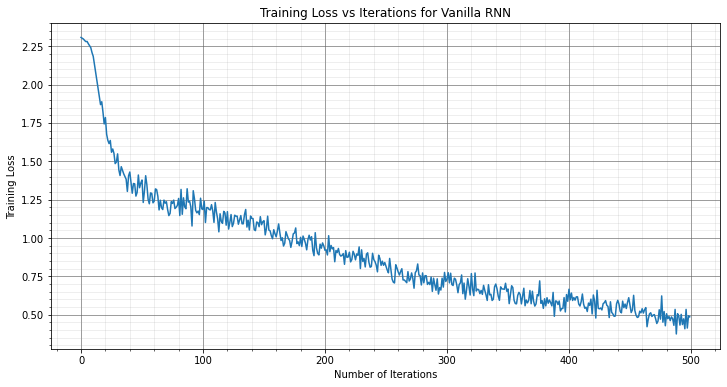

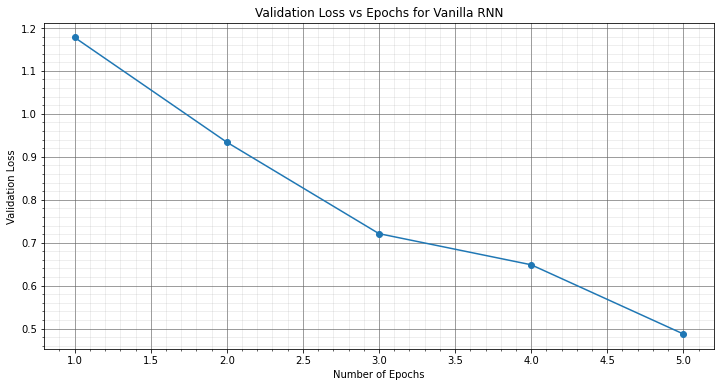

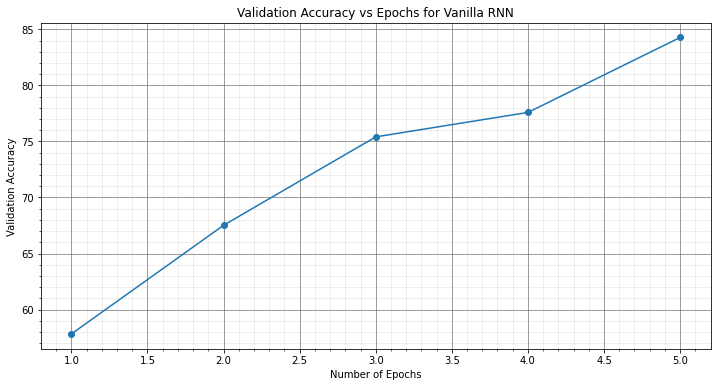

In [36]:
plotter(train_loss,val_loss,val_acc,"Vanilla RNN")

In [37]:
model1.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
      images = images.reshape(-1, 28, 28) 
      outputs = model1(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    print('Test Accuracy of the vanilla RNN model: {:.3f} %'.format((correct / total) * 100)) 

Test Accuracy of the vanilla RNN model: 84.690 %


###**LSTM**

In [39]:
class LSTM(nn.Module):
  def __init__(self):
    super(LSTM, self).__init__()
    self.lstm = nn.LSTM(28,128)
    self.layer2 = nn.Linear(128, 10)
    
  def forward(self, X):
    hiddenstate=torch.zeros(1,X.size(0),128)
    cellstate=torch.zeros(1,X.size(0),128)
    X=X.permute(1,0,2)
    out,(hs,cs) = self.lstm(X,(hiddenstate,cellstate)) 
    out = self.layer2(out[27])
    return out.reshape(500,10)

In [40]:
learning_rate = 0.001
epochs = 5
criterion2 = nn.CrossEntropyLoss()

In [41]:
train_loss = []
val_loss = []
val_acc = []

model2=LSTM()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)

for epoch in range(epochs):
  for i, (images, labels) in enumerate(trainloader):
    images = images.reshape(-1, 28, 28)
    outputs = model2(images)
    loss = criterion2(outputs, labels)
    train_loss.append(loss.item())
    
    optimizer2.zero_grad()
    loss.backward()
    optimizer2.step()
    
  iteration=0
  tempvalloss=0
  correctval=0    
  
  for images, labels in valloader:
    images = images.reshape(-1, 28, 28) 
    outputs = model2(images)
    loss = criterion2(outputs, labels)
    _, predicted = torch.max(outputs.data, 1)
    correctval += (predicted == labels).sum().item()
    iteration+=1
    tempvalloss+=loss.item()
      
  val_loss.append(tempvalloss/iteration)
  val_acc.append(correctval/100)
  print('Epoch [',epoch+1,'/',epochs,'] : completed.')

Epoch [ 1 / 5 ] : completed.
Epoch [ 2 / 5 ] : completed.
Epoch [ 3 / 5 ] : completed.
Epoch [ 4 / 5 ] : completed.
Epoch [ 5 / 5 ] : completed.


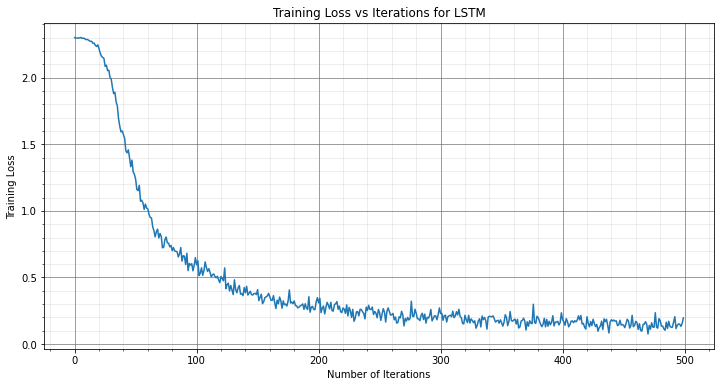

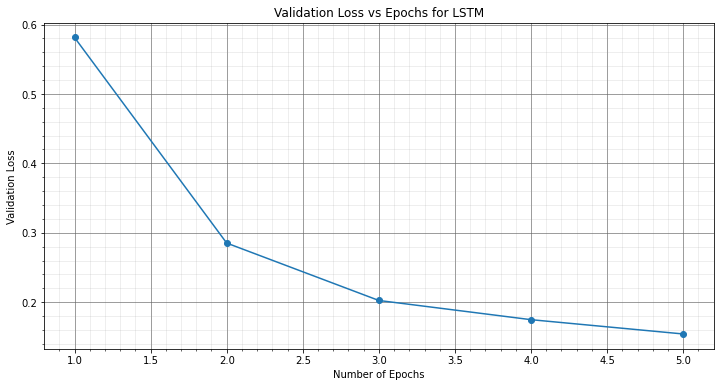

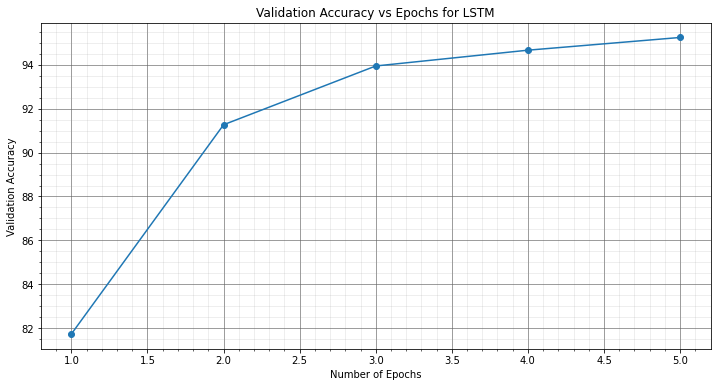

In [42]:
plotter(train_loss,val_loss,val_acc,"LSTM")

In [43]:
model2.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
      images = images.reshape(-1, 28, 28) 
      outputs = model2(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    print('Test Accuracy of LSTM model: {} %'.format((correct / total) * 100))

Test Accuracy of LSTM model: 95.26 %


###**Bidirectional RNN**

In [47]:
class Bi_RNN(nn.Module):
  def __init__(self):
    super(Bi_RNN, self).__init__()
    self.rnn = nn.RNN(28,128,1,bidirectional=True)
    self.layer2 = nn.Linear(128*2, 10)
    
  def forward(self, X):
    X = X.permute(1, 0, 2)
    hiddenlayer=torch.zeros(2,X.size(1),128)
    _,hiddenlayer = self.rnn(X,hiddenlayer)
    finp,binp=hiddenlayer[0],hiddenlayer[1]
    inp=torch.cat((finp,binp),dim=-1)
    out = self.layer2(inp)
    return out

In [48]:
learning_rate = 0.001
epochs = 5
criterion3 = nn.CrossEntropyLoss()

In [49]:
trainingloss_list = []
validationloss_list = []
validationaccuracy_list = []
model3=Bi_RNN()
optimizer3 = torch.optim.Adam(model3.parameters(), lr=learning_rate)

for epoch in range(epochs):
  for i, (images, labels) in enumerate(trainloader):
    images = images.reshape(-1, 28, 28)
    outputs = model3(images)
    loss = criterion3(outputs, labels)
    trainingloss_list.append(loss.item())
    
    optimizer3.zero_grad()
    loss.backward()
    optimizer3.step()
    
  iteration=0
  tempvalloss=0
  correctval=0    
  
  for images, labels in valloader:
    images = images.reshape(-1, 28, 28) 
    outputs = model3(images)
    loss = criterion3(outputs, labels)
    _, predicted = torch.max(outputs.data, 1)
    correctval += (predicted == labels).sum().item()
    iteration+=1
    tempvalloss+=loss.item()
      
  validationloss_list.append(tempvalloss/iteration)
  validationaccuracy_list.append(correctval/100)
  print('Epoch [',epoch+1,'/',epochs,'] : completed.')

Epoch [ 1 / 5 ] : completed.
Epoch [ 2 / 5 ] : completed.
Epoch [ 3 / 5 ] : completed.
Epoch [ 4 / 5 ] : completed.
Epoch [ 5 / 5 ] : completed.


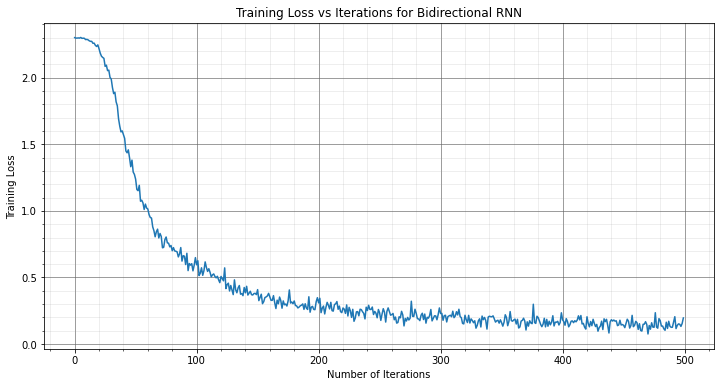

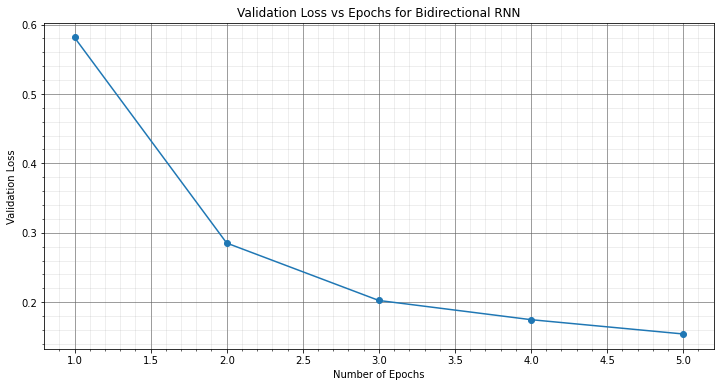

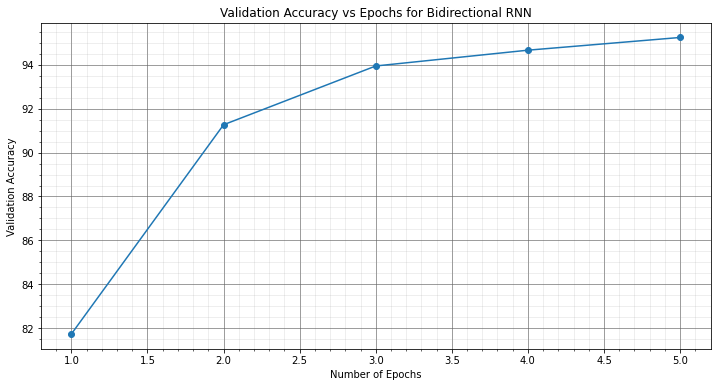

In [50]:
plotter(train_loss,val_loss,val_acc, "Bidirectional RNN")

In [51]:
model3.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
      # print(images.shape)
      images = images.reshape(-1, 28, 28) 
      outputs = model3(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    print('Test Accuracy of Bidirectional RNN model: {} %'.format((correct / total) * 100))

Test Accuracy of Bidirectional RNN model: 93.31 %


Prediction: [9. 8. 3. 3. 3.]
Real label: [9. 8. 3. 3. 3.]
Images:


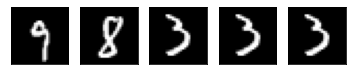

In [60]:
ix=1
a=(5*np.abs(np.random.rand(5))).astype(int)
predict=np.zeros(5)
actual=np.zeros(5)
fig,ax = plt.subplots()
for i in range(5):
  ax=plt.subplot(1,5,ix)
  ax.set_xticks([])
  ax.set_yticks([])
  im=ax.imshow(images[a[i]],cmap='gray')
  _,predicted=torch.max(model2(images)[a[i]],0)
  predict[i]=predicted.item()
  actual[i]=labels[a[i]]
  ix+=1
plt.show
print('Prediction:',predict)
print('Real label:',actual)
print('Images:')

#**QUESTION 2**

In [61]:
def get_rand_list(L):
  ranlist=np.random.randint(0,10,L)
  return ranlist

def getonehot(X):
  x_ohe = np.zeros((len(X), 10))
  x_ohe[np.arange(len(X)), X] = 1
  return x_ohe 

In [74]:
class LSTM_Q2(nn.Module):
  def __init__(self,hidsize):
    super(LSTM_Q2, self).__init__()
    self.hidsize=hidsize
    self.lstm = nn.LSTM(10,hidsize)
    self.layer2 = nn.Linear(hidsize, 10)
    
  def forward(self, X):
    hiddenstate=torch.zeros(1,X.size(0),self.hidsize)
    cellstate=torch.zeros(1,X.size(0),self.hidsize)
    X=X.permute(1,0,2)
    out,(hs,cs) = self.lstm(X,(hiddenstate,cellstate)) 
    out = self.layer2(out[-1])
    return out.reshape(1,10)

In [86]:
learning_rate = 0.002
epochs = 15
criterion4 = nn.CrossEntropyLoss()

In [87]:
train_ran_list=[]
val_ran_list=[]
test_ran_list=[]
for i in range(100):
  for j in range(3,11):
    train_ran_list.append(get_rand_list(j))
  L=np.random.randint(3,11)
  val_ran_list.append(get_rand_list(L))
  L=np.random.randint(3,11)
  test_ran_list.append(get_rand_list(L))   

In [88]:
K=1
train_loss_2=[]
val_acc_2=[]

train_loss_5=[]
val_acc_5=[]

train_loss_10=[]
val_acc_10=[]

iteration=0
tempvalloss=0
correctval=0  

model4_2=LSTM_Q2(2)
optimizer4_2 = torch.optim.Adam(model4_2.parameters(), lr=learning_rate)

for epoch in range(epochs):
  for i in range(len(train_ran_list)):  
    hotranlist=torch.zeros((1,len(train_ran_list[i]),10))
    hotranlist[0]=torch.from_numpy(getonehot(train_ran_list[i]))
    
    output=model4_2(hotranlist.float())
    _,predicted=torch.max(output.data,1)
    
    label=torch.tensor([train_ran_list[i][K]],dtype=torch.long)
    loss = criterion4(output, label.long())
    train_loss_2.append(loss.item())
    
    optimizer4_2.zero_grad()
    loss.backward()
    optimizer4_2.step()
  
  iteration=0
  tempvalloss=0
  correctval=0 
    
  for i in range(len(val_ran_list)):  
    hotranlist=torch.zeros((1,len(val_ran_list[i]),10))
    hotranlist[0]=torch.from_numpy(getonehot(val_ran_list[i]))
    
    output=model4_2(hotranlist.float())
    _,predicted=torch.max(output.data,1)
    
    label=torch.tensor([val_ran_list[i][K]],dtype=torch.long)
    _, predicted = torch.max(output.data, 1)
    correctval += (predicted == label).sum().item()
    iteration+=1
      
  val_acc_2.append(correctval/len(val_ran_list)*100)


model4_5=LSTM_Q2(5)
optimizer4_5 = torch.optim.Adam(model4_5.parameters(), lr=learning_rate)

for epoch in range(epochs):
  for i in range(len(train_ran_list)):  
    hotranlist=torch.zeros((1,len(train_ran_list[i]),10))
    hotranlist[0]=torch.from_numpy(getonehot(train_ran_list[i]))
    
    output=model4_5(hotranlist.float())
    _,predicted=torch.max(output.data,1)
    
    label=torch.tensor([train_ran_list[i][K]],dtype=torch.long)
    loss = criterion4(output, label.long())
    train_loss_5.append(loss.item())
    
    optimizer4_5.zero_grad()
    loss.backward()
    optimizer4_5.step()
    
  iteration=0
  tempvalloss=0
  correctval=0 
  
  for i in range(len(val_ran_list)):  
    hotranlist=torch.zeros((1,len(val_ran_list[i]),10))
    hotranlist[0]=torch.from_numpy(getonehot(val_ran_list[i]))
    
    output=model4_5(hotranlist.float())
    _,predicted=torch.max(output.data,1)
    
    label=torch.tensor([val_ran_list[i][K]],dtype=torch.long)
    _, predicted = torch.max(output.data, 1)
    correctval += (predicted == label).sum().item()
    iteration+=1
      
  val_acc_5.append(correctval/len(val_ran_list)*100)
  

model4_10=LSTM_Q2(10)
optimizer4_10 = torch.optim.Adam(model4_10.parameters(), lr=learning_rate)

for epoch in range(epochs):
  for i in range(len(train_ran_list)):  
    hotranlist=torch.zeros((1,len(train_ran_list[i]),10))
    hotranlist[0]=torch.from_numpy(getonehot(train_ran_list[i]))
    
    output=model4_10(hotranlist.float())
    _,predicted=torch.max(output.data,1)
    
    label=torch.tensor([train_ran_list[i][K]],dtype=torch.long)
    loss = criterion4(output, label.long())
    train_loss_10.append(loss.item())
    
    optimizer4_10.zero_grad()
    loss.backward()
    optimizer4_10.step()
    
  iteration=0
  tempvalloss=0
  correctval=0 

  for i in range(len(val_ran_list)):  
    hotranlist=torch.zeros((1,len(val_ran_list[i]),10))
    hotranlist[0]=torch.from_numpy(getonehot(val_ran_list[i]))
    
    output=model4_10(hotranlist.float())
    _,predicted=torch.max(output.data,1)
    
    label=torch.tensor([val_ran_list[i][K]],dtype=torch.long)
    _, predicted = torch.max(output.data, 1)
    correctval += (predicted == label).sum().item()
    iteration+=1
      
  val_acc_10.append(correctval/len(val_ran_list)*100)

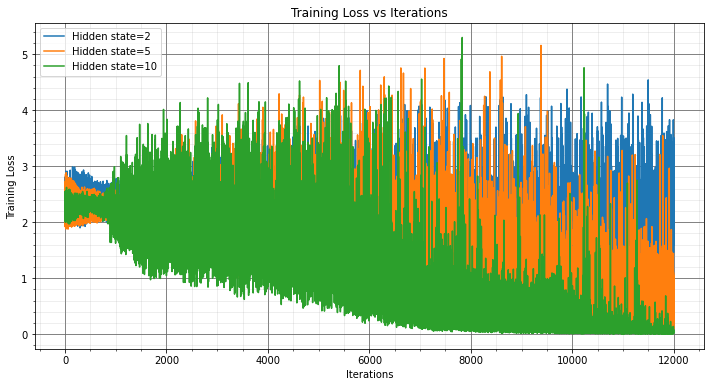

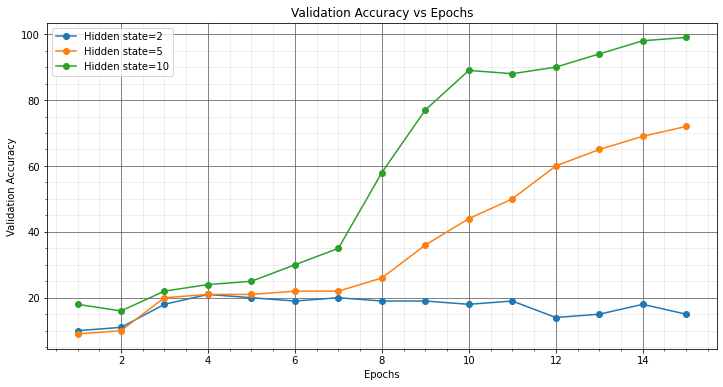

In [89]:
plt_1 = plt.figure(figsize=(12, 6))
plt.figure(1)
xtrainloss=np.arange(len(train_loss_2))
plt.plot(xtrainloss,train_loss_2,label="Hidden state=2")
plt.plot(xtrainloss,train_loss_5,label="Hidden state=5")
plt.plot(xtrainloss,train_loss_10,label="Hidden state=10")
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iterations')
plt.legend()

plt_1 = plt.figure(figsize=(12, 6))
plt.figure(2)
xvalloss=range(1,len(val_acc_2)+1)
plt.plot(xvalloss,val_acc_2,label="Hidden state=2",marker='o')
plt.plot(xvalloss,val_acc_5,label="Hidden state=5",marker='o')
plt.plot(xvalloss,val_acc_10,label="Hidden state=10",marker='o')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Epochs')
plt.legend()
plt.show()

In [90]:
model4_2.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i in range(len(test_ran_list)):
      hotranlist=torch.zeros((1,len(test_ran_list[i]),10))
      hotranlist[0]=torch.from_numpy(getonehot(test_ran_list[i]))
      output=model4_2(hotranlist.float())
      label=torch.tensor([test_ran_list[i][K]],dtype=torch.long)
      _, predicted = torch.max(output.data, 1)
      correct += (predicted == label).sum().item()

    print('Test Accuracy of the model with 2 hidden states on the 100 test samples: {} %'.format((correct / len(test_ran_list)) * 100))
    
model4_5.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i in range(len(test_ran_list)):
      hotranlist=torch.zeros((1,len(test_ran_list[i]),10))
      hotranlist[0]=torch.from_numpy(getonehot(test_ran_list[i]))
      output=model4_5(hotranlist.float())
      label=torch.tensor([test_ran_list[i][K]],dtype=torch.long)
      _, predicted = torch.max(output.data, 1)
      correct += (predicted == label).sum().item()

    print('Test Accuracy of the model with 5 hidden states on the 100 test samples: {} %'.format((correct / len(test_ran_list)) * 100))
    
model4_10.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i in range(len(test_ran_list)):
      hotranlist=torch.zeros((1,len(test_ran_list[i]),10))
      hotranlist[0]=torch.from_numpy(getonehot(test_ran_list[i]))
      output=model4_10(hotranlist.float())
      label=torch.tensor([test_ran_list[i][K]],dtype=torch.long)
      _, predicted = torch.max(output.data, 1)
      correct += (predicted == label).sum().item()

    print('Test Accuracy of the model with 10 hidden states on the 100 test samples: {} %'.format((correct / len(test_ran_list)) * 100))

Test Accuracy of the model with 2 hidden states on the 100 test samples: 19.0 %
Test Accuracy of the model with 5 hidden states on the 100 test samples: 69.0 %
Test Accuracy of the model with 10 hidden states on the 100 test samples: 99.0 %


In [91]:
for i in range(3,11):
  print("For Length",i)
  for j in range(3):
      a=get_rand_list(i)
      hotranlist=torch.zeros((1,len(a),10))
      hotranlist[0]=torch.from_numpy(getonehot(a))
      output=model4_10(hotranlist.float())
      label=torch.tensor([a[K]],dtype=torch.long)
      _, predicted = torch.max(output.data, 1)
      print("Array:",a,"Prediction at position 2:",predicted.item())

For Length 3
Array: [1 2 9] Prediction at position 2: 2
Array: [0 4 9] Prediction at position 2: 4
Array: [9 5 3] Prediction at position 2: 5
For Length 4
Array: [8 0 8 7] Prediction at position 2: 0
Array: [2 9 9 1] Prediction at position 2: 9
Array: [2 9 1 6] Prediction at position 2: 9
For Length 5
Array: [6 7 2 2 0] Prediction at position 2: 7
Array: [8 3 7 4 8] Prediction at position 2: 3
Array: [8 9 0 4 8] Prediction at position 2: 9
For Length 6
Array: [7 6 5 4 6 1] Prediction at position 2: 6
Array: [6 2 1 5 6 9] Prediction at position 2: 2
Array: [0 3 0 2 3 7] Prediction at position 2: 3
For Length 7
Array: [1 1 1 7 5 1 2] Prediction at position 2: 1
Array: [6 6 6 5 5 5 2] Prediction at position 2: 6
Array: [9 2 6 1 6 2 4] Prediction at position 2: 2
For Length 8
Array: [8 6 9 3 9 7 6 1] Prediction at position 2: 6
Array: [5 9 1 5 0 3 8 9] Prediction at position 2: 5
Array: [6 6 8 9 1 2 2 9] Prediction at position 2: 6
For Length 9
Array: [7 1 4 2 5 7 7 9 1] Prediction at posi

#**QUESTION 3**

In [24]:
def bin_generator(L):
  N1=np.random.randint(0,2**(L-1))
  N2=np.random.randint(0,2**(L-1))
  S=N1+N2
  binlen=L
  B1=np.zeros((1,binlen))
  B2=np.zeros((1,binlen))
  B3=np.zeros((binlen))
  b=np.flip(np.array(list(np.binary_repr(N1)), dtype=int))
  B1[0][0:len(b)]=b[0:]
  b=np.flip(np.array(list(np.binary_repr(N2)), dtype=int))
  B2[0][0:len(b)]=b[0:]
  b=np.flip(np.array(list(np.binary_repr(S)), dtype=int))
  B3[0:len(b)]=b[0:]
  return(np.concatenate((np.transpose(B1),np.transpose(B2)),axis=1),B3)  

In [37]:
train_X=[]
train_Y=[]
for i in range(250):
  L=np.random.randint(1,21)
  a,b=bin_generator(L)
  train_X.append(a)
  train_Y.append(b)
  
val_X=[]
val_Y=[]
for i in range(100):
  L=np.random.randint(1,21)
  a,b=bin_generator(L)
  val_X.append(a)
  val_Y.append(b)
  
test_X=[]
test_Y=[]
for j in range(1,21):
  for i in range(100):
    a,b=bin_generator(j)
    test_X.append(a)
    test_Y.append(b)

In [26]:
class LSTM_Q3(nn.Module):
  def __init__(self,hidsize):
    super(LSTM_Q3, self).__init__()
    self.hidsize=hidsize
    self.lstm = nn.LSTM(2,hidsize)
    self.layer2 = nn.Sequential(
        nn.Linear(hidsize,1),
        nn.Sigmoid())
    
  def forward(self, X):
    X=X.permute(1,0,2)
    hiddenstate=torch.zeros(1,X.size(1),self.hidsize)
    cellstate=torch.zeros(1,X.size(1),self.hidsize)
    out,(hs,cs) = self.lstm(X,(hiddenstate,cellstate))
    out = self.layer2(out)
    return out.reshape(X.size(0))

In [136]:
learning_rate = 0.1
epochs = 5
criterion5 = nn.MSELoss()
model5_3=LSTM_Q3(3)#model51=model5_3
optimizer5_3 = torch.optim.Adam(model5_3.parameters(), lr=learning_rate)
model5_10=LSTM_Q3(10)#model52=model5_10
optimizer5_10 = torch.optim.Adam(model5_10.parameters(), lr=learning_rate)

In [141]:
train_loss_3=[]
val_loss_3=[]
val_acc_3=[]
for epoch in range(epochs):
  for i in range(int(len(train_X))):
    a=torch.zeros((1,train_X[i].shape[0],train_X[i].shape[1]))
    a[0]=torch.from_numpy(train_X[i])
    output=model5_3(a.float())
    label=torch.tensor(np.transpose(train_Y[i]))
    loss = criterion5(output,label.float())
    train_loss_3.append(loss.item())
      
    optimizer5_3.zero_grad()
    loss.backward()
    optimizer5_3.step()
    
  iteration=0
  tempvalloss=0
  correctval=0 
    
  for i in range(len(val_X)):
    correct=0
    a=torch.zeros((1,val_X[i].shape[0],val_X[i].shape[1]))
    a[0]=torch.from_numpy(val_X[i])
    output=model5_3(a.float())
    label=torch.tensor(np.transpose(val_Y[i]))
    loss = criterion5(output,label.float())
    iteration+=1
    tempvalloss+=loss.item()
    
    predicted=torch.zeros(output.shape)
    predicted[output>=0.5]=1
    predicted[output<0.5]=0
    correct += (predicted == label.float()).sum().item()/len(label)
    
  val_acc_3.append(100*correct/iteration)
  val_loss_3.append(tempvalloss/iteration)
  print('Epoch [',epoch+1,'/',epochs,'] : completed.')

Epoch [ 1 / 5 ] : completed.
Epoch [ 2 / 5 ] : completed.
Epoch [ 3 / 5 ] : completed.
Epoch [ 4 / 5 ] : completed.
Epoch [ 5 / 5 ] : completed.


In [138]:
train_loss_10=[]
val_loss_10=[]
val_acc_10=[]
for epoch in range(epochs):
  for i in range(len(train_X)):
    a=torch.zeros((1,train_X[i].shape[0],train_X[i].shape[1]))
    a[0]=torch.from_numpy(train_X[i])
    output=model5_10(a.float())
    label=torch.tensor(np.transpose(train_Y[i]))
    loss = criterion5(output,label.float())
    train_loss_10.append(loss.item())
      
    optimizer5_10.zero_grad()
    loss.backward()
    optimizer5_10.step()
    
  iteration=0
  tempvalloss=0
  correctval=0 
    
  for i in range(len(val_X)):
    correct=0
    a=torch.zeros((1,val_X[i].shape[0],val_X[i].shape[1]))
    a[0]=torch.from_numpy(val_X[i])
    output=model5_10(a.float())
    label=torch.tensor(np.transpose(val_Y[i]))
    loss = criterion5(output,label.float())
    iteration+=1
    tempvalloss+=loss.item()
    
    predicted=torch.zeros(output.shape)
    predicted[output>=0.5]=1
    predicted[output<0.5]=0
    correct += (predicted == label.float()).sum().item()/len(label)
    
  val_acc_10.append(100*correct/iteration)
  val_loss_10.append(tempvalloss/iteration)
  print('Epoch [',epoch+1,'/',epochs,'] : completed.')

Epoch [ 1 / 5 ] : completed.
Epoch [ 2 / 5 ] : completed.
Epoch [ 3 / 5 ] : completed.
Epoch [ 4 / 5 ] : completed.
Epoch [ 5 / 5 ] : completed.


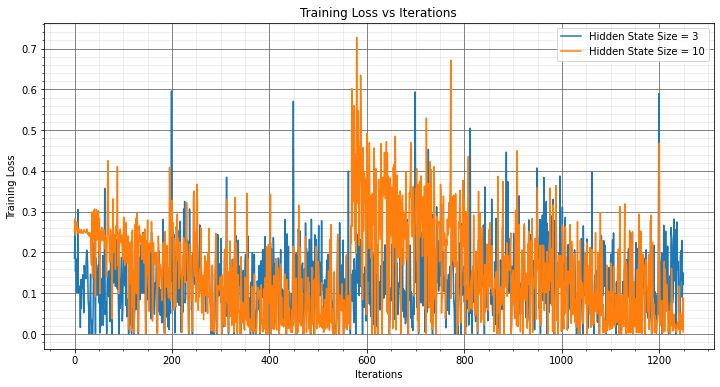

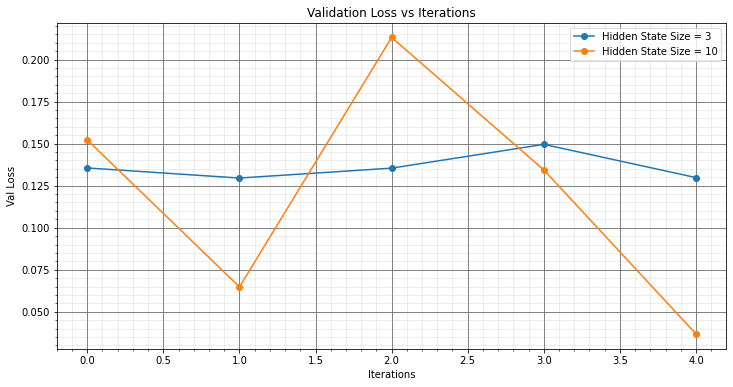

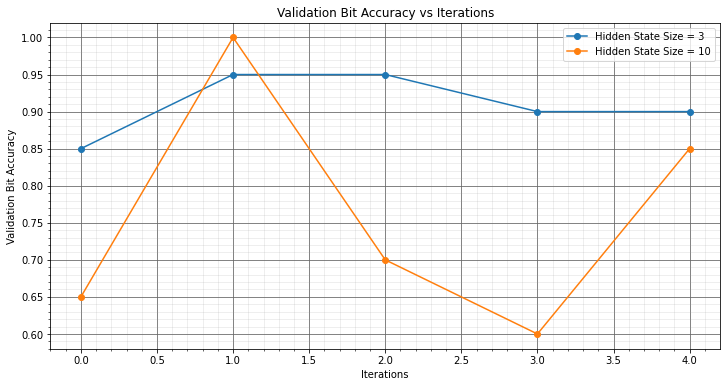

In [142]:
plt_1 = plt.figure(figsize=(12, 6))
plt.figure(1)
xtrainloss=np.arange(len(train_loss_3))
plt.plot(xtrainloss,train_loss_3,label="Hidden State Size = 3")
plt.plot(xtrainloss,train_loss_10,label="Hidden State Size = 10")
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iterations')
plt.legend()

plt_1 = plt.figure(figsize=(12, 6))
plt.figure(2)
xtestloss=np.arange(len(val_loss_3))
plt.plot(xtestloss,val_loss_3,label="Hidden State Size = 3",marker='o')
plt.plot(xtestloss,val_loss_10,label="Hidden State Size = 10",marker='o')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Iterations')
plt.ylabel('Val Loss')
plt.title('Validation Loss vs Iterations')
plt.legend()

plt_1 = plt.figure(figsize=(12, 6))
plt.figure(3)
xbittrain=np.arange(len(val_acc_3))
plt.plot(xbittrain,val_acc_3,label="Hidden State Size = 3",marker='o')
plt.plot(xbittrain,val_acc_10,label="Hidden State Size = 10",marker='o')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Iterations')
plt.ylabel('Validation Bit Accuracy')
plt.title('Validation Bit Accuracy vs Iterations')
plt.legend()


plt.show()


In [149]:
model5_3.eval()
correctarr1 = np.zeros(20)
correctarr2 = np.zeros(20)
with torch.no_grad():
    for i in range(len(test_X)):
      a=torch.zeros((1,test_X[i].shape[0],test_X[i].shape[1]))
      a[0]=torch.from_numpy(test_X[i])
      output=model5_3(a.float())
      label=torch.tensor(np.transpose(test_Y[i]))
      predicted=torch.zeros(output.shape)
      predicted[output>=0.5]=1
      predicted[output<0.5]=0
      correctarr1[len(label)-1] += (predicted == label.float()).sum().item()/(len(label))


    print('Accuracy for number of hidden states = 3:',(np.sum(correctarr1)/20))

model5_10.eval()    
with torch.no_grad():
    for i in range(len(test_X)):
      a=torch.zeros((1,test_X[i].shape[0],test_X[i].shape[1]))
      a[0]=torch.from_numpy(test_X[i])
      output=model5_10(a.float())
      label=torch.tensor(np.transpose(test_Y[i]))
      predicted=torch.zeros(output.shape)
      predicted[output>0.5]=1
      predicted[output<=0.5]=0
      correctarr2[len(label)-1] += (predicted == label.float()).sum().item()/(len(label))
    print('Accuracy for number of hidden states = 10:',(np.sum(correctarr2)/20))

Accuracy for number of hidden states = 3: 77.17988197990518
Accuracy for number of hidden states = 10: 97.47178618079548


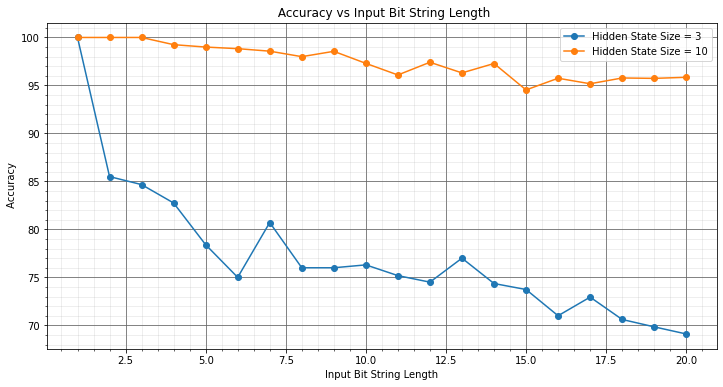

In [144]:
x=np.arange(1,21)
plt_1 = plt.figure(figsize=(12, 6))
plt.figure(1)
plt.plot(x,correctarr1,label="Hidden State Size = 3",marker='o')
plt.plot(x,correctarr2,label="Hidden State Size = 10",marker='o')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Input Bit String Length')
plt.ylabel(' Accuracy')
plt.title(' Accuracy vs Input Bit String Length')
plt.legend()
plt.show()

In [32]:
learning_rate = 0.08
epochs = 5
criterion5 = nn.MSELoss()
model5_5_mse=LSTM_Q3(5)
optimizer5_5_mse = torch.optim.Adam(model5_5_mse.parameters(), lr=learning_rate)
model5_5_ce=LSTM_Q3(5)
optimizer5_5_ce = torch.optim.Adam(model5_5_ce.parameters(), lr=learning_rate)

In [45]:
train_loss_5_mse=[]
val_loss_5_mse=[]
val_acc_5_mse=[]
for epoch in range(epochs):
  for i in range(int(len(train_X))):
    a=torch.zeros((1,train_X[i].shape[0],train_X[i].shape[1]))
    a[0]=torch.from_numpy(train_X[i])
    output=model5_5_mse(a.float())
    label=torch.tensor(np.transpose(train_Y[i]))
    loss = criterion5(output,label.float())
    train_loss_5_mse.append(loss.item())
      
    optimizer5_5_mse.zero_grad()
    loss.backward()
    optimizer5_5_mse.step()
    
  iteration=0
  tempvalloss=0
  correctval=0 
    
  for i in range(len(val_X)):
    correct=0
    a=torch.zeros((1,val_X[i].shape[0],val_X[i].shape[1]))
    a[0]=torch.from_numpy(val_X[i])
    output=model5_5_mse(a.float())
    label=torch.tensor(np.transpose(val_Y[i]))
    loss = criterion5(output,label.float())
    iteration+=1
    tempvalloss+=loss.item()
    
    predicted=torch.zeros(output.shape)
    predicted[output>=0.5]=1
    predicted[output<0.5]=0
    correct += (predicted == label.float()).sum().item()/len(label)
    
  val_acc_5_mse.append(100*correct/iteration)
  val_loss_5_mse.append(tempvalloss/iteration)
  print('Epoch [',epoch+1,'/',epochs,'] : completed.')

Epoch [ 1 / 5 ] : completed.
Epoch [ 2 / 5 ] : completed.
Epoch [ 3 / 5 ] : completed.
Epoch [ 4 / 5 ] : completed.
Epoch [ 5 / 5 ] : completed.


In [46]:
criterion5_ce=nn.CrossEntropyLoss()
train_loss_5_ce=[]
val_loss_5_ce=[]
val_acc_5_ce=[]
for epoch in range(epochs):
  for i in range(int(len(train_X))):
    a=torch.zeros((1,train_X[i].shape[0],train_X[i].shape[1]))
    a[0]=torch.from_numpy(train_X[i])
    output=model5_5_ce(a.float())
    label=torch.tensor(np.transpose(train_Y[i]))
    loss=criterion5_ce(output,label.float())
    train_loss_5_ce.append(loss.item())
      
    optimizer5_5_ce.zero_grad()
    loss.backward()
    optimizer5_5_ce.step()
    
  iteration=0
  tempvalloss=0
  correctval=0 
    
  for i in range(len(val_X)):
    correct=0
    a=torch.zeros((1,val_X[i].shape[0],val_X[i].shape[1]))
    a[0]=torch.from_numpy(val_X[i])
    output=model5_5_ce(a.float())
    label=torch.tensor(np.transpose(val_Y[i]))
    loss=criterion5_ce(output,label.float())
    iteration+=1
    tempvalloss+=loss.item()
    
    predicted=torch.zeros(output.shape)
    predicted[output>=0.5]=1
    predicted[output<0.5]=0
    correct += (predicted == label.float()).sum().item()/len(label)
    
  val_acc_5_ce.append(100*correct/iteration)
  val_loss_5_ce.append(tempvalloss/iteration)
  print('Epoch [',epoch+1,'/',epochs,'] : completed.')

Epoch [ 1 / 5 ] : completed.
Epoch [ 2 / 5 ] : completed.
Epoch [ 3 / 5 ] : completed.
Epoch [ 4 / 5 ] : completed.
Epoch [ 5 / 5 ] : completed.


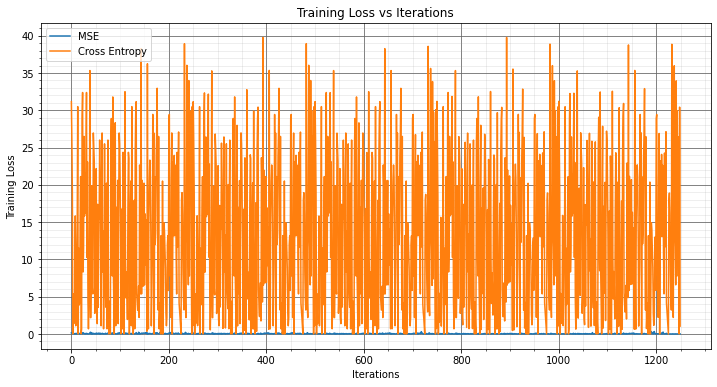

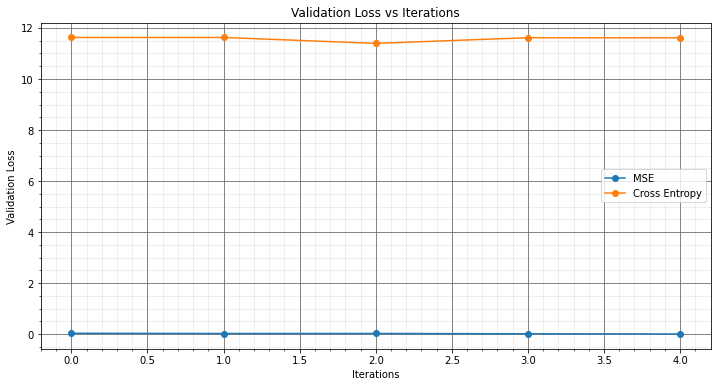

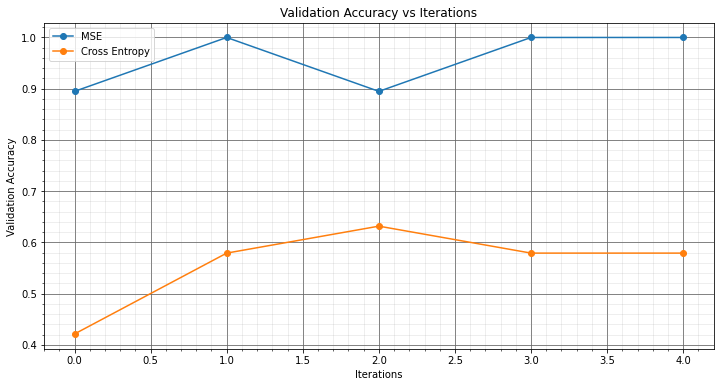

In [51]:
plt_1 = plt.figure(figsize=(12, 6))
plt.figure(1)
xtrainloss=np.arange(len(train_loss_5_mse))
plt.plot(xtrainloss,train_loss_5_mse,label="MSE")
plt.plot(xtrainloss,train_loss_5_ce,label="Cross Entropy")
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iterations')
plt.legend()

plt_1 = plt.figure(figsize=(12, 6))
plt.figure(2)
xtestloss=np.arange(len(val_loss_5_mse))
plt.plot(xtestloss,val_loss_5_mse,label="MSE",marker='o')
plt.plot(xtestloss,val_loss_5_ce,label="Cross Entropy",marker='o')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Iterations')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Iterations')
plt.legend()

plt_1 = plt.figure(figsize=(12, 6))
plt.figure(3)
xbittrain=np.arange(len(val_acc_5_mse))
plt.plot(xbittrain,val_acc_5_mse,label="MSE",marker='o')
plt.plot(xbittrain,val_acc_5_ce,label="Cross Entropy",marker='o')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Iterations')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Iterations')
plt.legend()


plt.show()

In [52]:
model5_5_mse.eval()
correctarr1 = np.zeros(20)
correctarr2 = np.zeros(20)
with torch.no_grad():
    for i in range(len(test_X)):
      a=torch.zeros((1,test_X[i].shape[0],test_X[i].shape[1]))
      a[0]=torch.from_numpy(test_X[i])
      output=model5_5_mse(a.float())
      label=torch.tensor(np.transpose(test_Y[i]))
      predicted=torch.zeros(output.shape)
      predicted[output>=0.5]=1
      predicted[output<0.5]=0
      correctarr1[len(label)-1] += (predicted == label.float()).sum().item()/(len(label))


    print('Accuracy with MSE:',(np.sum(correctarr1)/20))

model5_5_ce.eval()    
with torch.no_grad():
    for i in range(len(test_X)):
      a=torch.zeros((1,test_X[i].shape[0],test_X[i].shape[1]))
      a[0]=torch.from_numpy(test_X[i])
      output=model5_5_ce(a.float())
      label=torch.tensor(np.transpose(test_Y[i]))
      predicted=torch.zeros(output.shape)
      predicted[output>0.5]=1
      predicted[output<=0.5]=0
      correctarr2[len(label)-1] += (predicted == label.float()).sum().item()/(len(label))
    print('Accuracy with Cross Entropy:',(np.sum(correctarr2)/20))

Accuracy with MSE: 98.04869198654802
Accuracy with Cross Entropy: 46.0380288442208


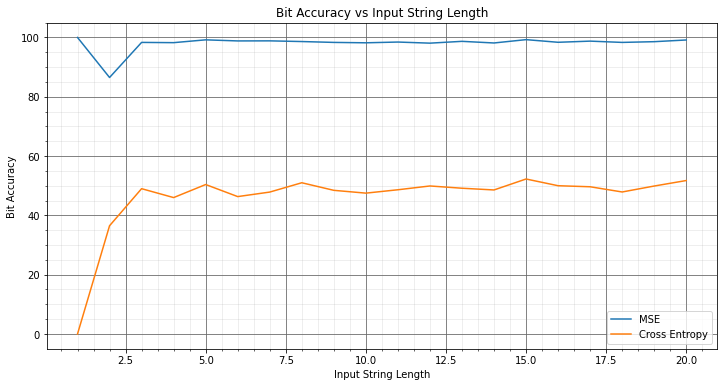

In [61]:
x=np.arange(1,21)
plt_1 = plt.figure(figsize=(12, 6))
plt.figure(1)
plt.plot(x,correctarr1,label="MSE")
plt.plot(x,correctarr2,label="Cross Entropy")
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Input String Length')
plt.ylabel('Bit Accuracy')
plt.title('Bit Accuracy vs Input String Length')
plt.legend()
plt.show()

In [54]:
train_X_3=[]
train_Y_3=[]
for i in range(250):
  a,b=bin_generator(3)
  train_X_3.append(a)
  train_Y_3.append(b)
  
train_X_5=[]
train_Y_5=[]
for i in range(250):
  a,b=bin_generator(5)
  train_X_5.append(a)
  train_Y_5.append(b)
  
train_X_10=[]
train_Y_10=[]
for i in range(250):
  a,b=bin_generator(10)
  train_X_10.append(a)
  train_Y_10.append(b)

In [55]:
learning_rate = 0.01
epochs = 5
criterion5 = nn.MSELoss()
model55=LSTM_Q3(5)
optimizer55 = torch.optim.Adam(model55.parameters(), lr=learning_rate)
model56=LSTM_Q3(5)
optimizer56 = torch.optim.Adam(model56.parameters(), lr=learning_rate)
model57=LSTM_Q3(5)
optimizer57 = torch.optim.Adam(model57.parameters(), lr=learning_rate)

In [57]:
train_loss_3=[]
val_loss_3=[]
val_acc_3=[]
for epoch in range(epochs):
  for i in range(len(train_X_3)):
    a=torch.zeros((1,train_X_3[i].shape[0],train_X_3[i].shape[1]))
    a[0]=torch.from_numpy(train_X_3[i])
    output=model55(a.float())
    label=torch.tensor(np.transpose(train_Y_3[i]))
    loss = criterion5(output,label.float())
    train_loss_3.append(loss.item())
      
    optimizer55.zero_grad()
    loss.backward()
    optimizer55.step()
    
  iteration=0
  tempvalloss=0
  correctval=0 
    
  for i in range(len(val_X)):
    correct=0
    a=torch.zeros((1,val_X[i].shape[0],val_X[i].shape[1]))
    a[0]=torch.from_numpy(val_X[i])
    output=model55(a.float())
    label=torch.tensor(np.transpose(val_Y[i]))
    loss = criterion5(output,label.float())
    iteration+=1
    tempvalloss+=loss.item()
    
    predicted=torch.zeros(output.shape)
    predicted[output>=0.5]=1
    predicted[output<0.5]=0
    correct += (predicted == label.float()).sum().item()/len(label)
    
  val_acc_3.append(100*correct/iteration)
  val_loss_3.append(tempvalloss/iteration)
  print('Epoch [',epoch+1,'/',epochs,'] : completed.')

Epoch [ 1 / 5 ] : completed.
Epoch [ 2 / 5 ] : completed.
Epoch [ 3 / 5 ] : completed.
Epoch [ 4 / 5 ] : completed.
Epoch [ 5 / 5 ] : completed.


In [58]:
train_loss_5=[]
val_loss_5=[]
val_acc_5=[]
for epoch in range(epochs):
  for i in range(int(len(train_X_5))):
    a=torch.zeros((1,train_X_5[i].shape[0],train_X_5[i].shape[1]))
    a[0]=torch.from_numpy(train_X_5[i])
    output=model56(a.float())
    label=torch.tensor(np.transpose(train_Y_5[i]))
    loss = criterion5(output,label.float())
    train_loss_5.append(loss.item())
      
    optimizer56.zero_grad()
    loss.backward()
    optimizer56.step()
    
  iteration=0
  tempvalloss=0
  correctval=0 
    
  for i in range(len(val_X)):
    correct=0
    a=torch.zeros((1,val_X[i].shape[0],val_X[i].shape[1]))
    a[0]=torch.from_numpy(val_X[i])
    output=model56(a.float())
    label=torch.tensor(np.transpose(val_Y[i]))
    loss = criterion5(output,label.float())
    iteration+=1
    tempvalloss+=loss.item()
    
    predicted=torch.zeros(output.shape)
    predicted[output>=0.5]=1
    predicted[output<0.5]=0
    correct += (predicted == label.float()).sum().item()/len(label)
    
  val_acc_5.append(100*correct/iteration)
  val_loss_5.append(tempvalloss/iteration)
  print('Epoch [',epoch+1,'/',epochs,'] : completed.')

Epoch [ 1 / 5 ] : completed.
Epoch [ 2 / 5 ] : completed.
Epoch [ 3 / 5 ] : completed.
Epoch [ 4 / 5 ] : completed.
Epoch [ 5 / 5 ] : completed.


In [60]:
train_loss_10=[]
val_loss_10=[]
val_acc_10=[]
for epoch in range(epochs):
  for i in range(int(len(train_X_10))):
    a=torch.zeros((1,train_X_10[i].shape[0],train_X_10[i].shape[1]))
    a[0]=torch.from_numpy(train_X_10[i])
    output=model57(a.float())
    label=torch.tensor(np.transpose(train_Y_10[i]))
    loss = criterion5(output,label.float())
    train_loss_10.append(loss.item())
      
    optimizer57.zero_grad()
    loss.backward()
    optimizer57.step()
    
  iteration=0
  tempvalloss=0
  correctval=0 
    
  for i in range(len(val_X)):
    correct=0
    a=torch.zeros((1,val_X[i].shape[0],val_X[i].shape[1]))
    a[0]=torch.from_numpy(val_X[i])
    output=model57(a.float())
    label=torch.tensor(np.transpose(val_Y[i]))
    loss = criterion5(output,label.float())
    iteration+=1
    tempvalloss+=loss.item()
    
    predicted=torch.zeros(output.shape)
    predicted[output>=0.5]=1
    predicted[output<0.5]=0
    correct += (predicted == label.float()).sum().item()/len(label)
    
  val_acc_10.append(100*correct/iteration)
  val_loss_10.append(tempvalloss/iteration)
  print('Epoch [',epoch+1,'/',epochs,'] : completed.')

Epoch [ 1 / 5 ] : completed.
Epoch [ 2 / 5 ] : completed.
Epoch [ 3 / 5 ] : completed.
Epoch [ 4 / 5 ] : completed.
Epoch [ 5 / 5 ] : completed.


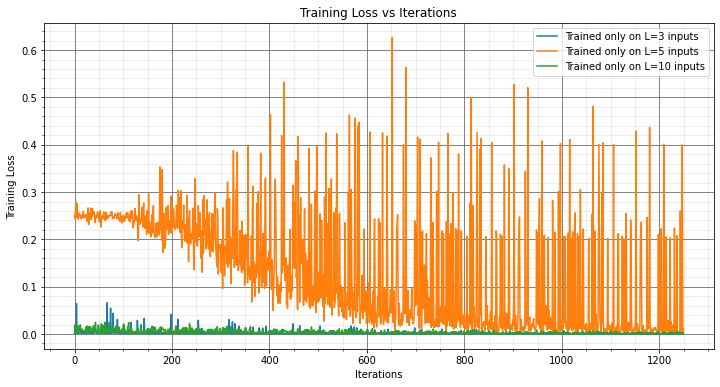

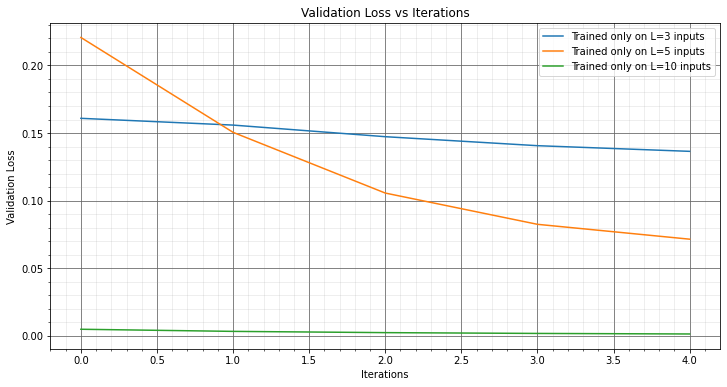

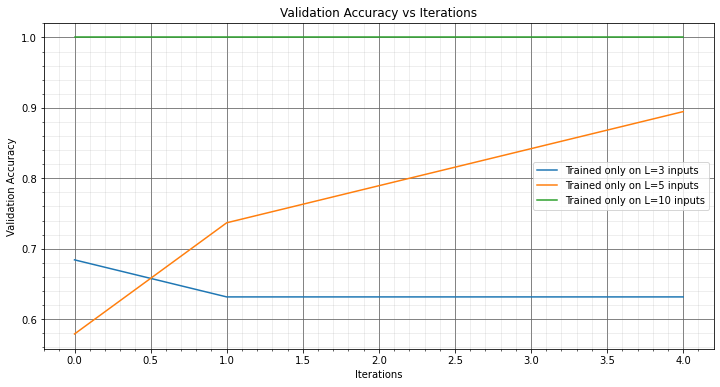

In [63]:
plt_1 = plt.figure(figsize=(12, 6))
plt.figure(1)
xtrainloss=np.arange(len(train_loss_3))
plt.plot(xtrainloss,train_loss_3,label="Trained only on L=3 inputs")
plt.plot(xtrainloss,train_loss_5,label="Trained only on L=5 inputs")
plt.plot(xtrainloss,train_loss_10,label="Trained only on L=10 inputs")
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iterations')
plt.legend()

plt_1 = plt.figure(figsize=(12, 6))
plt.figure(2)
xtestloss=np.arange(len(val_loss_3))
plt.plot(xtestloss,val_loss_3,label="Trained only on L=3 inputs")
plt.plot(xtestloss,val_loss_5,label="Trained only on L=5 inputs")
plt.plot(xtestloss,val_loss_10,label="Trained only on L=10 inputs")
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Iterations')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Iterations')
plt.legend()

plt_1 = plt.figure(figsize=(12, 6))
plt.figure(3)
xbittrain=np.arange(len(val_acc_3))
plt.plot(xbittrain,val_acc_3,label="Trained only on L=3 inputs")
plt.plot(xbittrain,val_acc_5,label="Trained only on L=5 inputs")
plt.plot(xbittrain,val_acc_10,label="Trained only on L=10 inputs")
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Iterations')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Iterations')
plt.legend()

plt.show()

In [64]:
model55.eval()
correctarr1 = np.zeros(20)
correctarr2 = np.zeros(20)
correctarr3 = np.zeros(20)
with torch.no_grad():
    for i in range(len(test_X)):
      a=torch.zeros((1,test_X[i].shape[0],test_X[i].shape[1]))
      a[0]=torch.from_numpy(test_X[i])
      output=model55(a.float())
      label=torch.tensor(np.transpose(test_Y[i]))
      predicted=torch.zeros(output.shape)
      predicted[output>=0.5]=1
      predicted[output<0.5]=0
      correctarr1[len(label)-1] += (predicted == label.float()).sum().item()/(len(label))


    print('Accuracy when trained on L=3 inputs:',(np.sum(correctarr1)/20))

model56.eval()    
with torch.no_grad():
    for i in range(len(test_X)):
      a=torch.zeros((1,test_X[i].shape[0],test_X[i].shape[1]))
      a[0]=torch.from_numpy(test_X[i])
      output=model56(a.float())
      label=torch.tensor(np.transpose(test_Y[i]))
      predicted=torch.zeros(output.shape)
      predicted[output>0.5]=1
      predicted[output<=0.5]=0
      correctarr2[len(label)-1] += (predicted == label.float()).sum().item()/(len(label))
    print('Accuracy when trained on L=5 inputs:',(np.sum(correctarr2)/20))
    
model57.eval()    
with torch.no_grad():
    for i in range(len(test_X)):
      a=torch.zeros((1,test_X[i].shape[0],test_X[i].shape[1]))
      a[0]=torch.from_numpy(test_X[i])
      output=model57(a.float())
      label=torch.tensor(np.transpose(test_Y[i]))
      predicted=torch.zeros(output.shape)
      predicted[output>0.5]=1
      predicted[output<=0.5]=0
      correctarr3[len(label)-1] += (predicted == label.float()).sum().item()/(len(label))
    print('Accuracy when trained on L=10 inputs:',(np.sum(correctarr3)/20))

Accuracy when trained on L=3 inputs: 78.5151106225216
Accuracy when trained on L=5 inputs: 92.19544692901694
Accuracy when trained on L=10 inputs: 100.0


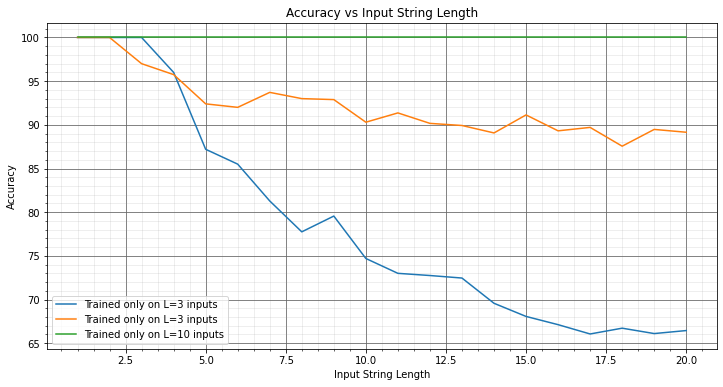

In [66]:
x=np.arange(1,21)
plt_1=plt.figure(figsize=(12,6))
plt.figure(1)
plt.plot(x,correctarr1,label="Trained only on L=3 inputs")
plt.plot(x,correctarr2,label="Trained only on L=3 inputs")
plt.plot(x,correctarr3,label="Trained only on L=10 inputs")
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Input String Length')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Input String Length')
plt.legend()
plt.show()